**Import modules and .txt files as dataframe, then plot to see data**

In [283]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import scipy

In [284]:
## Import nmdb data (OULU, THUL, SOPO)
colnames = ['datetime', 'OULU', 'THUL', 'SOPO']
filenames = ['data_2min_fd2015.txt', 'data_2min_fd2021.txt',
             'data_2min_2005_1.txt', 'data_2min_2005_2.txt', 'data_2min_2005_3.txt',
             'data_2min_2022_1.txt', 'data_2min_2022_2.txt', 'data_2min_2022_3.txt',
             'data_2min_2023_1.txt', 'data_2min_2023_2.txt', 'data_2min_2023_3.txt',
             'data_2min_2024_1.txt', 'data_2min_2024_2.txt', 'data_2min_2024_3.txt']
dataframes = []

def read_and_clean_txt(filename, colnames):
    stations = colnames[1:]
    df = pd.read_csv(filename, sep=';', comment='#', names=colnames) # Import
    df = df.drop(index=0).reset_index(drop=True) # Remove first row
    df.datetime = pd.to_datetime(df.datetime, format="%Y-%m-%d %H:%M:%S") # Convert to datetime
    for s in stations: # Convert invalid data to nan
        df[s] = pd.to_numeric(df[s], errors='coerce')
        df[s] = df[s].bfill()   # backward fill
    return df
        
for filename in filenames:
    df = read_and_clean_txt(filename, colnames)
    dataframes.append(df) # Add to df list

# Extract as individual dataframes
fd15, fd21, data05_1, data05_2, data05_3, data22_1, data22_2, data22_3, data23_1, data23_2, data23_3, data24_1, data24_2, data24_3 = dataframes

# Merge data05, data22, data23, data24
data05 = pd.concat([data05_1, data05_2, data05_3], ignore_index=True)
data22 = pd.concat([data22_1, data22_2, data22_3], ignore_index=True)
data23 = pd.concat([data23_1, data23_2, data23_3], ignore_index=True)
data24 = pd.concat([data24_1, data24_2, data24_3], ignore_index=True)


## Import nmdb data (AATB, lMKS) -- Downloaded later on
# Concatenate FD data to first 2 dataframes
def merge_with_filename(df_to_merge, filename, colnames):
    another_df = read_and_clean_txt(filename, colnames)
    df_merged = df_to_merge.merge(another_df, on='datetime', how='outer')
    return df_merged

colnames = ['datetime', 'AATB', 'LMKS']
fd15 = merge_with_filename(fd15, 'data_2min_fd2015_LMKS+AATB.txt', colnames)
fd21 = merge_with_filename(fd21, 'data_2min_fd2021_LMKS+AATB.txt', colnames)

# Concatenate FD data to the rest of the dataframes
for s in ['AATB', 'LMKS']:
    colnames = ['datetime', s]
    data05 = merge_with_filename(data05, f'data_2min_2005_{s}.txt', colnames)
    data22 = merge_with_filename(data22, f'data_2min_2022_{s}.txt', colnames)
    data23 = merge_with_filename(data23, f'data_2min_2023_{s}.txt', colnames)
    data24 = merge_with_filename(data24, f'data_2min_2024_{s}.txt', colnames)

# Reset dataframes
dataframes = [fd15, fd21, data05, data22, data23, data24]

# Show dataframe
stations = ['OULU', 'THUL', 'SOPO', 'AATB', 'LMKS']  # Final station list
data05

,datetime,OULU,THUL,SOPO,AATB,LMKS
0,2005-01-01 00:00:00,102.878,115.610,287.055,1368.85,422.034
1,2005-01-01 00:02:00,101.313,114.330,286.695,1395.75,422.425
2,2005-01-01 00:04:00,103.435,116.180,284.750,1374.85,430.050
3,2005-01-01 00:06:00,100.498,115.440,284.735,1377.65,438.716
4,2005-01-01 00:08:00,100.452,116.925,286.435,1383.70,425.375
...,...,...,...,...,...,...
250555,2005-12-14 23:50:00,105.435,121.250,NaN,1443.90,449.992
250556,2005-12-14 23:52:00,104.610,122.380,NaN,1436.60,446.092
250557,2005-12-14 23:54:00,106.469,120.665,NaN,1433.85,446.350
250558,2005-12-14 23:56:00,106.546,122.065,NaN,1449.35,444.250


In [285]:
# Draw baseline for each offset station data
def draw_baselines(ax, offset, interval):
    lw = 0.5
    for n in range(-2, 3):
        ax.axhline(y=offset + n * interval, linestyle="--", linewidth=lw, color='black')

# Set change x-axis to day of year and limit to 0-350
def set_xaxis_DoY(ax, times):
    ax.xaxis.set_major_formatter( # Set x-axis to DoY
        FuncFormatter(lambda x, _: mdates.num2date(x).timetuple().tm_yday)
    )
    
    # Limit x-axis DoY to 0-350
    year0 = times.dt.year.min()
    xmin = pd.Timestamp(year0, 1, 1) + pd.Timedelta(days=0)
    xmax = pd.Timestamp(year0, 1, 1) + pd.Timedelta(days=350)
    ax.set_xlim(xmin, xmax)

    # Set ticker interval to be 25 days counting from 0
    ticks = [xmin + pd.Timedelta(days=d) for d in range(0, 351, 25)]
    ax.set_xticks(ticks)

def set_xaxis_DoY_4times(ax):
    ax0, ax1, ax2, ax3 = ax
    set_xaxis_DoY(ax0, data05.datetime)
    set_xaxis_DoY(ax1, data22.datetime)
    set_xaxis_DoY(ax2, data23.datetime)
    set_xaxis_DoY(ax3, data24.datetime)

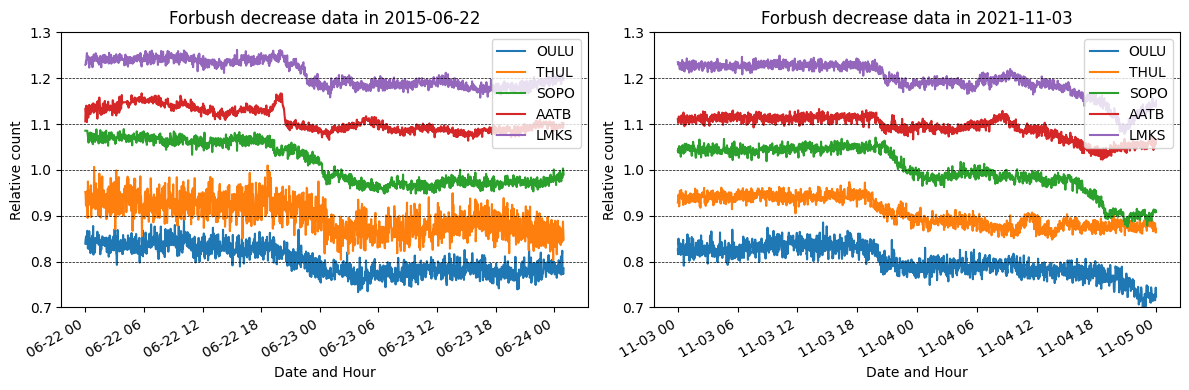

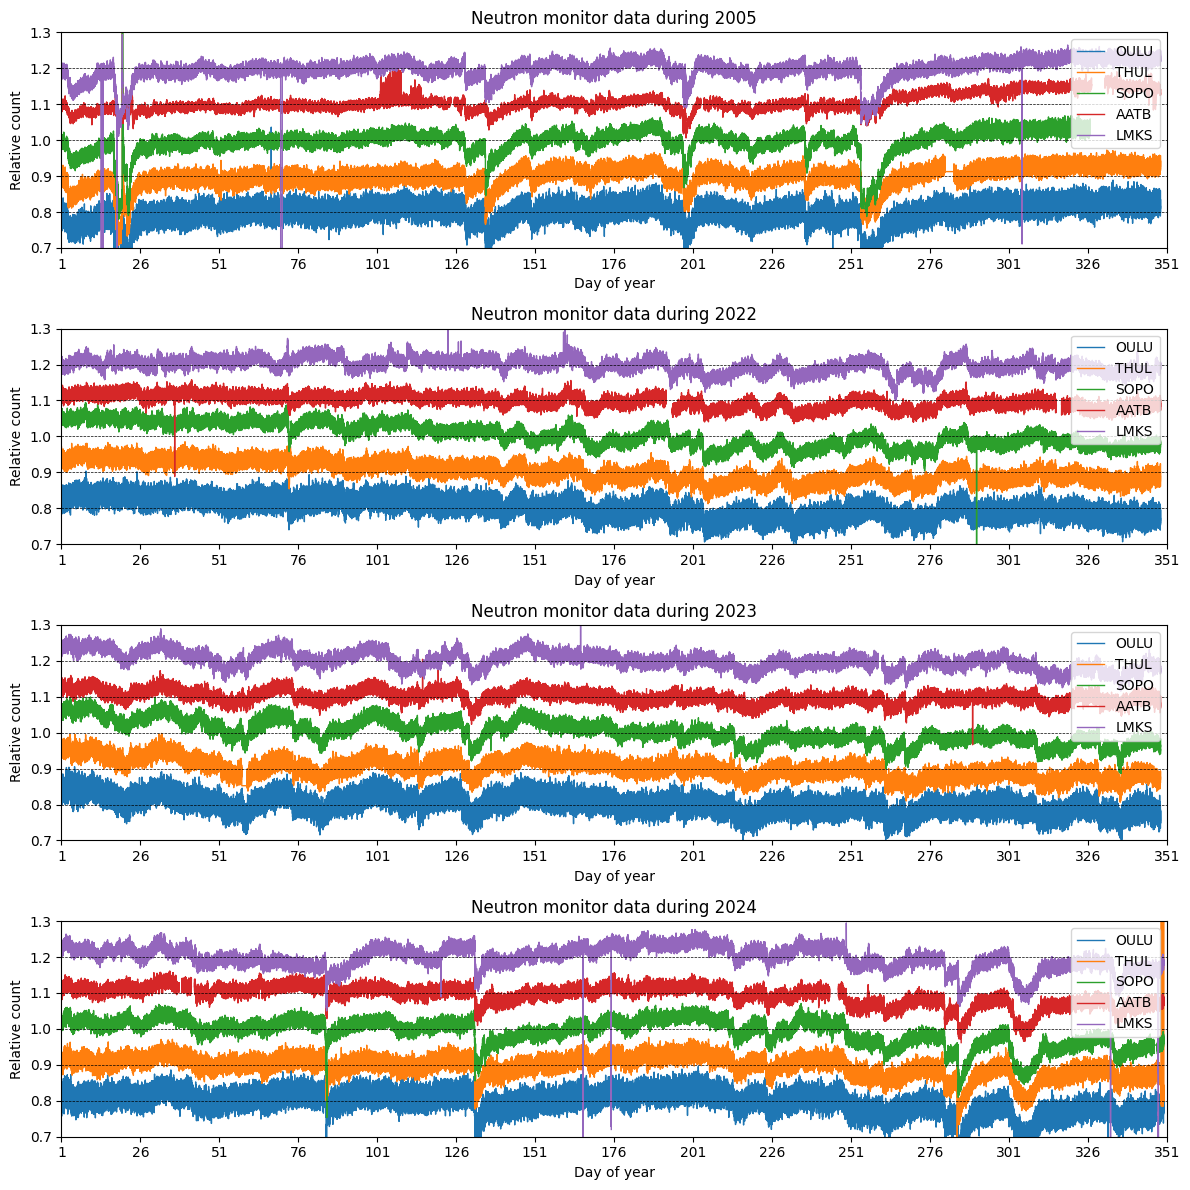

In [273]:
# Plot Forbush decrease data
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = ax

for i, s in enumerate(stations):
    shift = (i-2) * 0.1
    ax1.plot(fd15.datetime, fd15[s] / fd15[s].median() + shift, label=s)
    ax2.plot(fd21.datetime, fd21[s] / fd21[s].median() + shift, label=s)

ax1.set_title('Forbush decrease data in 2015-06-22')
ax2.set_title('Forbush decrease data in 2021-11-03')

for a in ax:
    a.set_ylabel('Relative count')
    a.set_xlabel('Date and Hour')
    a.legend(loc='upper right')
    a.set_ylim(0.7, 1.3)
    draw_baselines(a, 1, 0.1)
    
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Plot year-long neutron monitor data
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
ax0, ax1, ax2, ax3 = ax

for i, s in enumerate(stations):
    shift = (i-2) * 0.1
    ax0.plot(data05.datetime, data05[s] / data05[s].median() + shift, label=s, linewidth=1)
    ax1.plot(data22.datetime, data22[s] / data22[s].median() + shift, label=s, linewidth=1)
    ax2.plot(data23.datetime, data23[s] / data23[s].median() + shift, label=s, linewidth=1)
    ax3.plot(data24.datetime, data24[s] / data24[s].median() + shift, label=s, linewidth=1)

set_xaxis_DoY_4times(ax)
ax0.set_title('Neutron monitor data during 2005')
ax1.set_title('Neutron monitor data during 2022')
ax2.set_title('Neutron monitor data during 2023')
ax3.set_title('Neutron monitor data during 2024')

for a in ax:
    a.set_ylabel('Relative count')
    a.set_xlabel('Day of year')
    a.legend(loc='upper right')
    a.set_ylim(0.7, 1.3)
    draw_baselines(a, 1, 0.1)

plt.tight_layout()
plt.show()

**Signal processing before applying CCF!**

Long-term signal movement removal with from-running-mean (12 h) calculations

In [288]:
def from_rolling_mean(signal): # from 12-hour rolling mean of smoothed signal
    minutes = 60 * 12
    window = int(minutes/2)

    rolling_mean = signal.rolling(window=window, min_periods=1).mean()  
    signal_frm = signal - rolling_mean
    return signal_frm

In [289]:
# Get from-rolling-mean data
for df in dataframes:
    for s in stations:
        df[f'{s}_frm'] = from_rolling_mean(df[s])

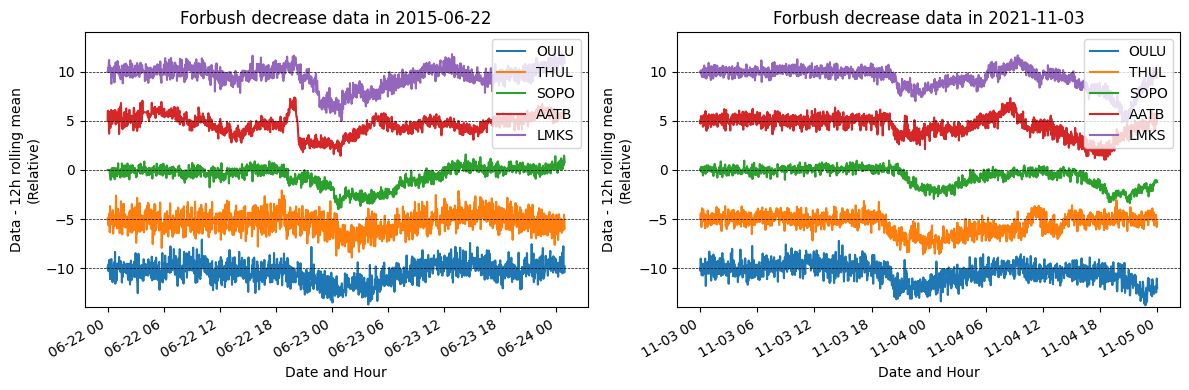

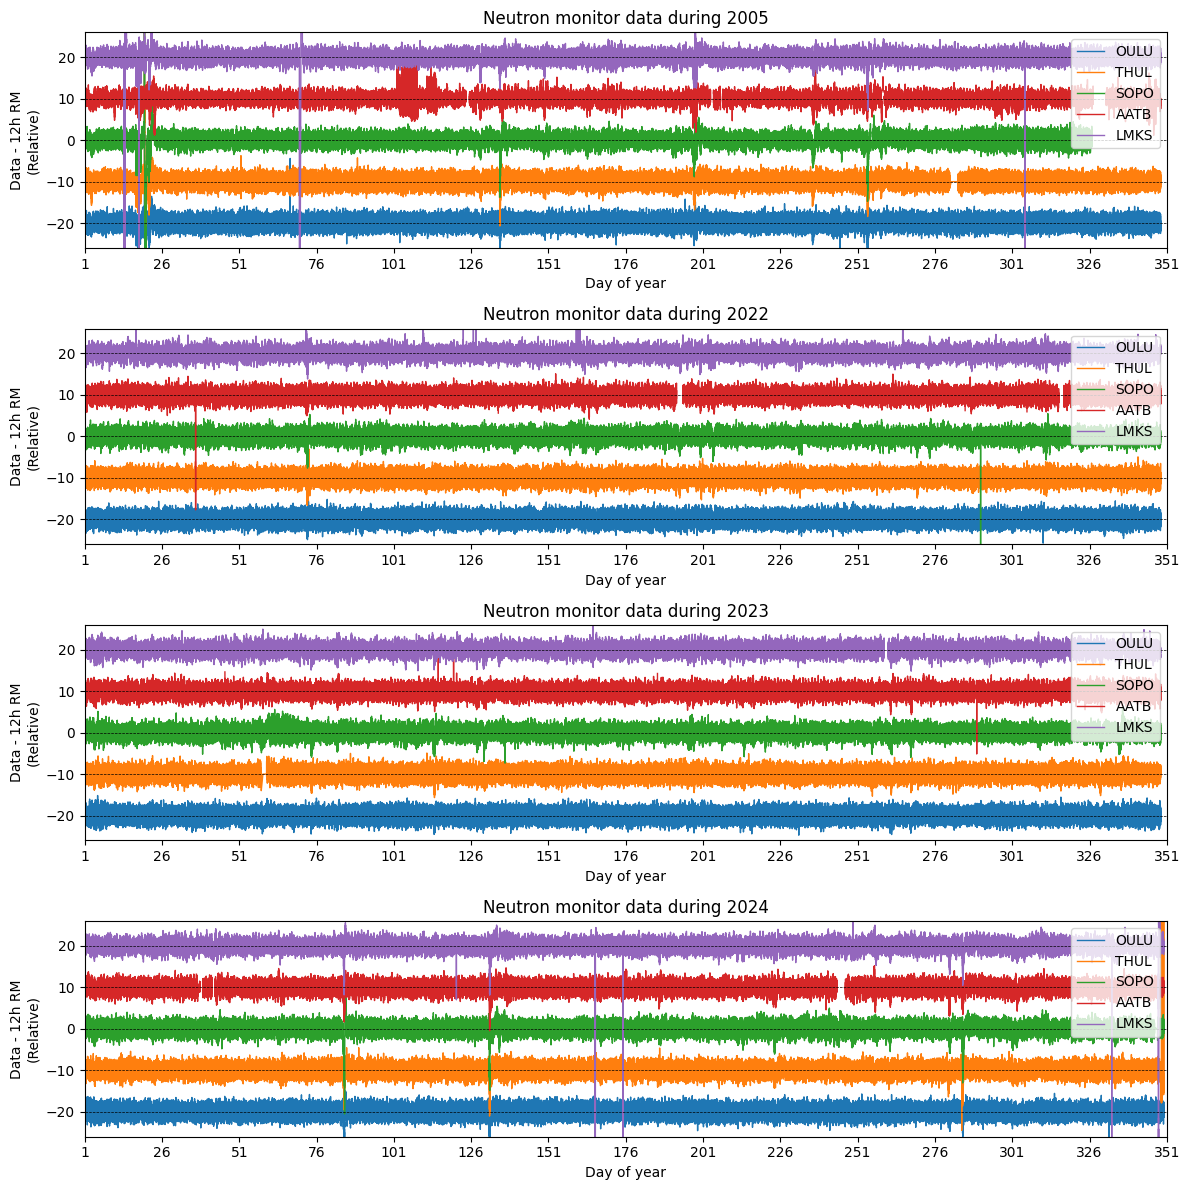

In [305]:
# Plot Forbush decrease data (from 12h rolling mean)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax1, ax2 = ax

def onesigma(df):
    one_sigma = 0.5 * (np.nanpercentile(df, 84) - np.nanpercentile(df, 16))
    return one_sigma

for i, s in enumerate(stations):
    shift = (i-2) * 5
    colname = f'{s}_frm'
    ax1.plot(fd15.datetime, fd15[colname] / onesigma(fd15[colname]) + shift, label=s)
    ax2.plot(fd21.datetime, fd21[colname] / onesigma(fd21[colname]) + shift, label=s)

ax1.set_title('Forbush decrease data in 2015-06-22')
ax2.set_title('Forbush decrease data in 2021-11-03')

for a in ax:
    a.set_ylabel('Data - 12h rolling mean\n(Relative)')
    a.set_xlabel('Date and Hour')
    a.legend(loc='upper right')
    draw_baselines(a, 0, 5)
    a.set_ylim(-14, 14)
    
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

# Plot year-long neutron monitor data (from running mean)
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
ax0, ax1, ax2, ax3 = ax

for i, s in enumerate(stations):
    shift = (i-2) * 10
    colname = f'{s}_frm'
    ax0.plot(data05.datetime, data05[colname] / onesigma(data05[colname]) + shift, label=s, linewidth=1)
    ax1.plot(data22.datetime, data22[colname] / onesigma(data22[colname]) + shift, label=s, linewidth=1)
    ax2.plot(data23.datetime, data23[colname] / onesigma(data23[colname]) + shift, label=s, linewidth=1)
    ax3.plot(data24.datetime, data24[colname] / onesigma(data24[colname]) + shift, label=s, linewidth=1)

set_xaxis_DoY_4times(ax)
ax0.set_title('Neutron monitor data during 2005')
ax1.set_title('Neutron monitor data during 2022')
ax2.set_title('Neutron monitor data during 2023')
ax3.set_title('Neutron monitor data during 2024')

for a in ax:
    a.set_ylabel('Data - 12h RM\n(Relative)')
    a.set_xlabel('Day of year')
    a.legend(loc='upper right')
    draw_baselines(a, 0, 10)
    a.set_ylim(-26, 26)

plt.tight_layout()
plt.show()

**Discrete-time cross correlation of NM signal and historical FD signal**

In [306]:
# Cross-correlation
def CCF(signal, fd):
    # Makes nan to zero to avoid null results
    signal_clean = np.nan_to_num(signal, nan=0.0)
    fd_clean = np.nan_to_num(fd, nan=0.0)

    # Compute CCF
    # For visualization and CCF thresholding, return relative CCF which is eseentially z-score of CCF
    CCF = scipy.signal.correlate(signal_clean, fd_clean, mode='full')
    CCF_med, CCF_std = np.nanmedian(CCF), 0.5 * (np.nanpercentile(CCF, 84) - np.nanpercentile(CCF, 16))
    relative_CCF = (CCF - CCF_med) / CCF_std
    
    lags = np.arange(-len(fd)+1, len(signal))
    # Lags to day of year (2-min interval)
    DoY = lags / (30 * 24)
    return DoY, relative_CCF

**Compute cross-correlation and plot**

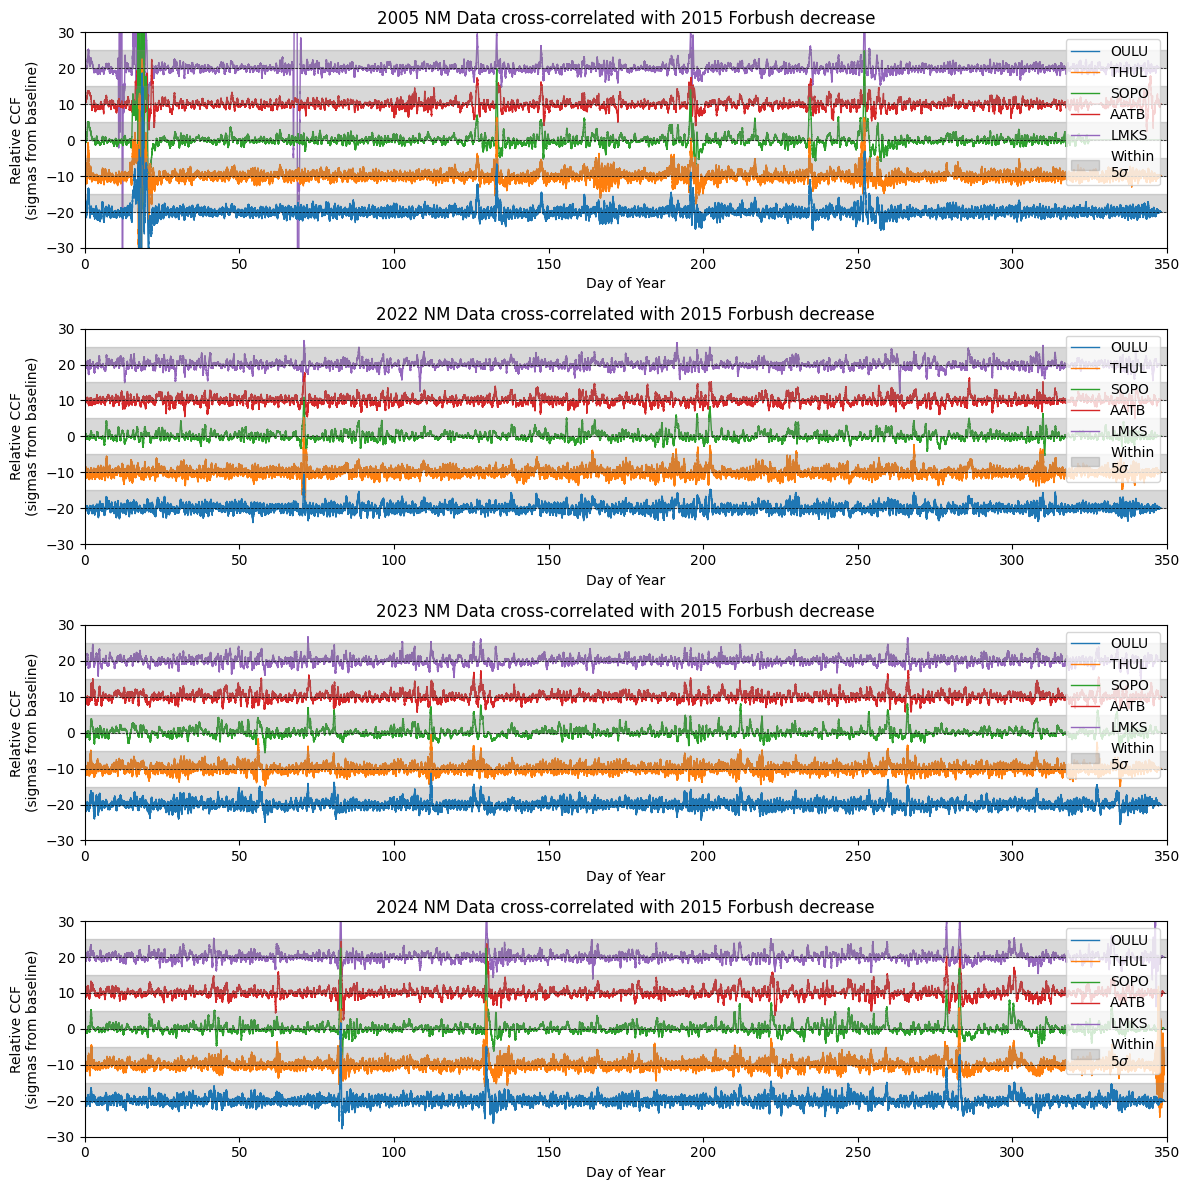

In [308]:
# Plot year-long CCF
fig, ax = plt.subplots(4, 1, figsize=(12, 12))
ax0, ax1, ax2, ax3 = ax

for i, s in enumerate(stations):
    shift = (i-2) * 10
    station_colname = f'{s}_frm'
    doy05, ccf05 = CCF(data05[station_colname], fd15[station_colname])
    doy22, ccf22 = CCF(data22[station_colname], fd15[station_colname])
    doy23, ccf23 = CCF(data23[station_colname], fd15[station_colname])
    doy24, ccf24 = CCF(data24[station_colname], fd15[station_colname])

    ax0.plot(doy05, ccf05 + shift, label=s, linewidth=1, zorder=-shift/10)
    ax1.plot(doy22, ccf22 + shift, label=s, linewidth=1, zorder=-shift/10)
    ax2.plot(doy23, ccf23 + shift, label=s, linewidth=1, zorder=-shift/10)
    ax3.plot(doy24, ccf24 + shift, label=s, linewidth=1, zorder=-shift/10)

ax0.set_title('2005 NM Data cross-correlated with 2015 Forbush decrease')
ax1.set_title('2022 NM Data cross-correlated with 2015 Forbush decrease')
ax2.set_title('2023 NM Data cross-correlated with 2015 Forbush decrease')
ax3.set_title('2024 NM Data cross-correlated with 2015 Forbush decrease')

for a in ax:
    a.set_ylabel('Relative CCF\n(sigmas from baseline)')
    a.set_xlabel('Day of Year')
    a.set_xlim(0, 350)
    a.set_ylim(-30, 30)
    draw_baselines(a, 0, 10)

    alpha=0.3
    a.axhspan(20, 25, color='grey', alpha=alpha)
    a.axhspan(10, 15, color='grey', alpha=alpha)
    a.axhspan(0, 5, color='grey', alpha=alpha, label='Within\n$5\sigma$') 
    a.axhspan(-10, -5, color='grey', alpha=alpha) 
    a.axhspan(-20, -15, color='grey', alpha=alpha) 

    a.legend(loc='upper right')

plt.tight_layout()
plt.show()

**Record all times with relative CCF > 5 sigma in 5 stations simultaneously**